# Geothermal and Machine Learning Sandbox

# Skeleton of an Variational Bayes Artificial Neural Network (BNN) in PyTorch applied to Nevada PFA Geothermal Resources Dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import math

import pickle

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from scipy.stats import kurtosis

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Load packages to create dataset
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import Dataset
from torch import Tensor

# from torchvision import models
from torchsummary import summary

import datetime
import time

from pathlib import Path
import sys

import h5py

from tqdm.notebook import trange, tqdm

## BEGIN data preprocessing

## load preprocessed data and trained model

In [2]:
# myHome = str(Path.home())

In [3]:
path = '../../datasets/'
modelPath = './'

filename = 'PFA_features&labels_march2021_tc2_imbalanced_SmoothLSS_FSS_df.h5'
# modelFilename = 'BNN_model_trial_4.19.torch'
modelFilename = 'BNN_model_trial_2.35.torch'

hf5File = path+filename
modelFile = modelPath+modelFilename

In [4]:
f = h5py.File(hf5File, 'r')

def keys(f):
    return [key for key in f.keys()]

key_list = keys(f)
print(key_list)

f.close()

['X', 'XyInfo', 'dfInfo', 'dfn', 'nullIndexes', 'scaler', 'y']


In [5]:
dfn = pd.read_hdf(hf5File, key='dfn')
nullIndexes = pd.read_hdf(hf5File, key='nullIndexes')

# dfXAll = pd.read_hdf(hf5File, key='X')
# dfyAll = pd.read_hdf(hf5File, key='y')
# XyInfo = pd.read_hdf(hf5File, key='XyInfo')

In [6]:
print( dfn.shape, nullIndexes.shape)

(1728000, 20) (30528,)


In [7]:
dfn.head()

,Local-StructuralSetting,Local-QuaternaryFaultRecency,Local-QuaternaryFaultSlipDilation,Local-QuaternaryFaultSlipRate,QuaternaryFaultTraces,HorizGravityGradient2,HorizMagneticGradient2,GeodeticStrainRate,QuaternarySlipRate,FaultRecency,FaultSlipDilationTendency2,Earthquakes,Heatflow,GravityDensity,MagneticDensity,GeochemistryTemperature2,Silica_Distance,TufaOrTravertine_Distance,DEM-30m,FavorableStructuralSettings_Distance
0,-0.523680,-0.568900,-0.399442,-0.568584,0.521096,-0.506811,-1.146319,1.738459,-0.641083,0.664854,-0.469155,2.209502,0.047583,1.320938,1.645851,-0.185826,0.585108,1.083581,0.615938,-0.004188
1,-0.523768,-0.569068,-0.399476,-0.568743,0.521096,-0.192541,-1.146319,1.738459,-0.641083,0.664854,-0.459131,2.211017,0.055473,1.205579,1.645851,-0.185826,0.583483,1.082302,0.510190,0.010133
2,-0.523942,-0.569398,-0.399542,-0.569055,0.521096,0.115757,-1.146319,1.738459,-0.641083,0.664854,-0.407871,2.217023,0.062990,1.205579,1.645851,-0.185826,0.581873,1.081095,0.303852,0.026057
3,-0.524196,-0.569881,-0.399638,-0.569513,0.524190,0.339483,-1.146319,1.738459,-0.641083,0.664854,-0.368710,2.211017,0.070240,1.090220,1.645851,-0.185826,0.580277,1.079959,0.347699,0.043545
4,-0.524525,-0.570503,-0.399762,-0.570102,0.533434,0.436512,-1.146319,1.738459,-0.630559,0.640521,-0.363559,2.208005,0.077179,1.090220,1.645851,-0.185826,0.578696,1.078894,0.437972,0.062554


In [8]:
nullIndexes.head()

0    209080
1    209081
2    209082
3    209083
4    209084
dtype: int64

In [9]:
columns=dfn.columns.to_list()

In [10]:
columns

['Local-StructuralSetting',
 'Local-QuaternaryFaultRecency',
 'Local-QuaternaryFaultSlipDilation',
 'Local-QuaternaryFaultSlipRate',
 'QuaternaryFaultTraces',
 'HorizGravityGradient2',
 'HorizMagneticGradient2',
 'GeodeticStrainRate',
 'QuaternarySlipRate',
 'FaultRecency',
 'FaultSlipDilationTendency2',
 'Earthquakes',
 'Heatflow',
 'GravityDensity',
 'MagneticDensity',
 'GeochemistryTemperature2',
 'Silica_Distance',
 'TufaOrTravertine_Distance',
 'DEM-30m',
 'FavorableStructuralSettings_Distance']

## select feature set

In [11]:
featureSets = [

# MASTER SET 1
################################# 0
['QuaternaryFaultTraces',
 'HorizGravityGradient2',
 'HorizMagneticGradient2',
 'GeodeticStrainRate',
 'QuaternarySlipRate',
 'FaultRecency',
 'FaultSlipDilationTendency2',
 'Earthquakes',
 'Heatflow',
 'DEM-30m',
],

]

print (len(featureSets))

1


In [12]:
feature_set = 0

columns = featureSets[feature_set]

columns

['QuaternaryFaultTraces',
 'HorizGravityGradient2',
 'HorizMagneticGradient2',
 'GeodeticStrainRate',
 'QuaternarySlipRate',
 'FaultRecency',
 'FaultSlipDilationTendency2',
 'Earthquakes',
 'Heatflow',
 'DEM-30m']

## END data preprocessing

## predict over study area

In [13]:
Xall = dfn.copy()

In [14]:
Xall.head()

,Local-StructuralSetting,Local-QuaternaryFaultRecency,Local-QuaternaryFaultSlipDilation,Local-QuaternaryFaultSlipRate,QuaternaryFaultTraces,HorizGravityGradient2,HorizMagneticGradient2,GeodeticStrainRate,QuaternarySlipRate,FaultRecency,FaultSlipDilationTendency2,Earthquakes,Heatflow,GravityDensity,MagneticDensity,GeochemistryTemperature2,Silica_Distance,TufaOrTravertine_Distance,DEM-30m,FavorableStructuralSettings_Distance
0,-0.523680,-0.568900,-0.399442,-0.568584,0.521096,-0.506811,-1.146319,1.738459,-0.641083,0.664854,-0.469155,2.209502,0.047583,1.320938,1.645851,-0.185826,0.585108,1.083581,0.615938,-0.004188
1,-0.523768,-0.569068,-0.399476,-0.568743,0.521096,-0.192541,-1.146319,1.738459,-0.641083,0.664854,-0.459131,2.211017,0.055473,1.205579,1.645851,-0.185826,0.583483,1.082302,0.510190,0.010133
2,-0.523942,-0.569398,-0.399542,-0.569055,0.521096,0.115757,-1.146319,1.738459,-0.641083,0.664854,-0.407871,2.217023,0.062990,1.205579,1.645851,-0.185826,0.581873,1.081095,0.303852,0.026057
3,-0.524196,-0.569881,-0.399638,-0.569513,0.524190,0.339483,-1.146319,1.738459,-0.641083,0.664854,-0.368710,2.211017,0.070240,1.090220,1.645851,-0.185826,0.580277,1.079959,0.347699,0.043545
4,-0.524525,-0.570503,-0.399762,-0.570102,0.533434,0.436512,-1.146319,1.738459,-0.630559,0.640521,-0.363559,2.208005,0.077179,1.090220,1.645851,-0.185826,0.578696,1.078894,0.437972,0.062554


## select only those features used for training

In [15]:
Xall = Xall[columns]

In [16]:
Xall.head()

,QuaternaryFaultTraces,HorizGravityGradient2,HorizMagneticGradient2,GeodeticStrainRate,QuaternarySlipRate,FaultRecency,FaultSlipDilationTendency2,Earthquakes,Heatflow,DEM-30m
0,0.521096,-0.506811,-1.146319,1.738459,-0.641083,0.664854,-0.469155,2.209502,0.047583,0.615938
1,0.521096,-0.192541,-1.146319,1.738459,-0.641083,0.664854,-0.459131,2.211017,0.055473,0.510190
2,0.521096,0.115757,-1.146319,1.738459,-0.641083,0.664854,-0.407871,2.217023,0.062990,0.303852
3,0.524190,0.339483,-1.146319,1.738459,-0.641083,0.664854,-0.368710,2.211017,0.070240,0.347699
4,0.533434,0.436512,-1.146319,1.738459,-0.630559,0.640521,-0.363559,2.208005,0.077179,0.437972


In [17]:
len(Xall)

1728000

In [18]:
Xall = Xall.copy().to_numpy()

# Xall

In [19]:
Xall.shape

(1728000, 10)

# Build model

In [20]:
# setting DEVICE on GPU if available, else CPU
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# DEVICE = torch.device('cpu')
print('Using DEVICE:', DEVICE)
print()

#Additional Info when using cuda
if DEVICE.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    
LOADER_KWARGS = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}

Using DEVICE: cuda

NVIDIA GeForce RTX 2070
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


## vanilla pytorch bayes by backprop

### global variables

In [21]:
class Gaussian(object):
    def __init__(self, mu, rho):
        super().__init__()
        self.mu = mu
        self.rho = rho
        self.normal = torch.distributions.Normal(0,1)
    
    @property
    def sigma(self):
        return torch.log1p(torch.exp(self.rho))
    
    def sample(self):
#         epsilon = self.normal.sample(self.rho.size()).to(DEVICE)
        epsilon = self.normal.sample().to(DEVICE)
        return self.mu + self.sigma * epsilon
    
    def entropy(self, input):
#         entropy = 0.5 * torch.log(2 * math.pi * math.e * self.sigma**2)
        entropy = -self.normal.log_prob(input).exp() * self.normal.log_prob(input)
        return entropy.sum()

    def log_prob(self, input):
        return (- math.log(math.sqrt(2 * math.pi))
                - torch.log(self.sigma)
                - ((input - self.mu) ** 2) / (2 * self.sigma ** 2)).sum()

In [22]:
from scipy.stats import gennorm

class GenNormal(object):
    def __init__(self, beta, scale):
        super().__init__()
        self.beta = beta.cpu().numpy()
        self.scale = scale.cpu().numpy()
        self.gennormal = gennorm(self.beta, loc=0.0, scale=self.scale)
    
    @property
    def sigma(self):
        return self.gennormal.std()
    
    def sample(self):
        rv = self.gennormal.rvs(self.scale.shape[0])
        rv = torch.FloatTensor(rv).to(DEVICE)
        return rv
    
    def entropy(self, input):
        x = input.cpu().detach().numpy()
        entropy = -self.gennormal.pdf(x) * self.gennormal.logpdf(x)
        entropy = torch.FloatTensor(entropy)
        return entropy.sum()

    def log_prob(self, input):
        x = input.cpu().detach().numpy()
#         x = input
        logprob = self.gennormal.logpdf(x)
        logprob = torch.FloatTensor(logprob)
        return logprob.sum()

In [23]:
class Normal(object):
    def __init__(self, scale):
        super().__init__()
        self.scale = scale
        self.normal = torch.distributions.Normal(loc=0.0, scale=self.scale)
        
    def sample(self):
        sample = self.normal.sample().to(DEVICE)
        return sample
    
    def entropy(self):
        entropy = self.normal.entropy()
        return entropy

    def log_prob(self, input):
        prob = self.normal.log_prob(input)
        return prob.sum()

## prior starting parameters

In [24]:
BETAw = torch.FloatTensor([10]).to(DEVICE)
BETAb = torch.FloatTensor([10]).to(DEVICE)

SCALEw = torch.FloatTensor([0.3]).to(DEVICE)
SCALEb = torch.FloatTensor([0.3]).to(DEVICE)

## Bayesian modules

In [25]:
class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        
        self.in_features = in_features
        self.out_features = out_features

        # Weight parameters
        self.weight_mu  = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-0.2, 0.2))
        self.weight_rho = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-5,-4))
        self.weight = Gaussian(self.weight_mu, self.weight_rho)
        
        # Bias parameters
        self.bias_mu  = nn.Parameter(torch.Tensor(out_features).uniform_(-0.2, 0.2))
        self.bias_rho = nn.Parameter(torch.Tensor(out_features).uniform_(-5,-4))
        self.bias = Gaussian(self.bias_mu, self.bias_rho)
        
        # Prior distributions
#         self.weight_prior = GenNormal(BETAw, SCALEw)
#         self.bias_prior   = GenNormal(BETAb, SCALEb)

        self.weight_prior = Normal(SCALEw)
        self.bias_prior   = Normal(SCALEb)

        self.log_prior = 0
        self.log_variational_posterior = 0

    def forward(self, input, sample=False, calculate_log_probs=False):
        if self.training or sample:
            weight = self.weight.sample()
            bias = self.bias.sample()
        else:
            weight = self.weight.mu
            bias = self.bias.mu
        if self.training or calculate_log_probs:
            self.log_prior = self.weight_prior.log_prob(weight) + self.bias_prior.log_prob(bias)
            self.log_variational_posterior = self.weight.log_prob(weight) + self.bias.log_prob(bias)
        else:
            self.log_prior, self.log_variational_posterior = 0, 0

        return F.linear(input, weight, bias)

In [26]:
class BayesianNetwork(nn.Module):
    def __init__(self, nFeatures, nHidden, nLabels, complexityWeight):
        super().__init__()
        self.nFeatures = nFeatures
        self.nHidden   = nHidden
        self.nLabels   = nLabels
        
        self.complexityWeight = complexityWeight
        
        self.l1 = BayesianLinear(self.nFeatures, self.nHidden)
        self.l2 = BayesianLinear(self.nHidden, self.nHidden)
        self.l3 = BayesianLinear(self.nHidden, self.nLabels)
        
        self.LeakyRelu  = nn.LeakyReLU(0.1)
        self.BatchNorm  = nn.BatchNorm1d(self.nHidden)
        self.dropout    = nn.Dropout(p=0.3)
        self.LogSoftmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x, sample=False):
        x = x.view(-1, self.nFeatures)
        
        x = self.l1(x, sample)
#         x = self.BatchNorm(x)
        x = self.LeakyRelu(x)

        x = self.l2(x, sample)
        x = self.LeakyRelu(x)

        x = self.l3(x, sample)
        x = self.LogSoftmax(x)
        
        return x
    
    def mfvi_forward(self, inputs, stat=None, q=None, sample_nbr=10):
        """
        Perform mean-field variational inference for the variational estimator model:
            Performs sample_nbr forward passes with uncertainty on the weights, 
            returning its mean and standard deviation
        """
        # logits from all samples - are these logsoftmax called logits?
        logits = torch.stack([self(inputs, sample=True) for _ in range(sample_nbr)])
        # convert logits to probability
        probability = torch.exp(logits)
        
        if   stat == 'mean':
            value = torch.mean(probability, dim=0)
        elif stat == 'stddev':
            value = torch.std(probability, dim=0)
        elif stat == 'mode':
            value, _ = torch.mode(probability, dim=0)
        elif stat == 'quantile':
            value = torch.quantile(probability, q, dim=0)
        else:
            value = torch.tensor([0.0])            
        return value

    def log_prior(self):
        return self.l1.log_prior \
               + self.l2.log_prior \
               + self.l3.log_prior
    
    def log_variational_posterior(self):
        return self.l1.log_variational_posterior \
               + self.l2.log_variational_posterior \
               + self.l3.log_variational_posterior
    
    def get_weights(self, param):
        if param == 'samples':
            return self.l1.weight.sample(), self.l2.weight.sample(), self.l3.weight.sample()
        elif param == 'sigmas':
            return self.l1.weight.sigma, self.l2.weight.sigma, self.l3.weight.sigma
        elif param == 'means':
            return self.l1.weight.mu, self.l2.weight.mu, self.l3.weight.mu
    
    def get_biases(self, param):
        if param == 'samples':
            return self.l1.bias.sample(), self.l2.bias.sample(), self.l3.bias.sample()
        elif param == 'sigmas':
            return self.l1.bias.sigma, self.l2.bias.sigma, self.l3.bias.sigma
        elif param == 'means':
            return self.l1.bias.mu, self.l2.bias.mu, self.l3.bias.mu

    def sample_elbo(self, input, target, samples=3):
        outputs = torch.zeros(samples, BATCH_SIZE, self.nLabels).to(DEVICE)
        log_priors = torch.zeros(samples).to(DEVICE)
        log_variational_posteriors = torch.zeros(samples).to(DEVICE)
        
        for i in range(samples):
            outputs[i] = self(input, sample=True) # this is same as "forward"
            log_priors[i] = self.log_prior()
            log_variational_posteriors[i] = self.log_variational_posterior()

        log_prior = log_priors.mean()
        log_variational_posterior = log_variational_posteriors.mean()

        negative_log_likelihood = F.nll_loss(outputs.mean(0), target, reduction='mean')

        loss = self.complexityWeight*(log_variational_posterior - log_prior) + negative_log_likelihood

        return loss, log_prior, log_variational_posterior, negative_log_likelihood

## load trained model

In [27]:
net = torch.load(modelFile)

net.eval()

summary(net, Xall.shape, col_names=("input_size", "output_size", "num_params"), verbose=2, depth=2);

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
├─BayesianLinear: 1-1                    [-1, 10]                  [-1, 16]                  352
|    └─weight_mu
|    └─weight_rho
├─LeakyReLU: 1-2                         [-1, 16]                  [-1, 16]                  --
├─BayesianLinear: 1-3                    [-1, 16]                  [-1, 16]                  544
|    └─weight_mu
|    └─weight_rho
├─LeakyReLU: 1-4                         [-1, 16]                  [-1, 16]                  --
├─BayesianLinear: 1-5                    [-1, 16]                  [-1, 2]                   68
|    └─weight_mu
|    └─weight_rho
├─LogSoftmax: 1-6                        [-1, 2]                   [-1, 2]                   --
Total params: 964
Trainable params: 964
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 65.92
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 65.92


In [28]:
param = 'means'

weightsM = np.hstack([net.get_weights(param)[0].cpu().detach().numpy().flatten(), 
                     net.get_weights(param)[1].cpu().detach().numpy().flatten(),
                     net.get_weights(param)[2].cpu().detach().numpy().flatten()])
biasesM  = np.hstack([net.get_biases(param)[0].cpu().detach().numpy().flatten(), 
                     net.get_biases(param)[1].cpu().detach().numpy().flatten(),
                     net.get_biases(param)[2].cpu().detach().numpy().flatten()])

kurw = kurtosis(weightsM, fisher=False)
kurb = kurtosis(biasesM, fisher=False)

print (weightsM.mean(), weightsM.std())
print (biasesM.mean(), biasesM.std())
print (kurw, kurb)

0.0032437055 0.09800366
0.027473401 0.114612244
35.79783565941384 4.753361723443161


In [29]:
param = 'sigmas'

weightsS = np.hstack([net.get_weights(param)[0].cpu().detach().numpy().flatten(), 
                     net.get_weights(param)[1].cpu().detach().numpy().flatten(),
                     net.get_weights(param)[2].cpu().detach().numpy().flatten()])
biasesS  = np.hstack([net.get_biases(param)[0].cpu().detach().numpy().flatten(), 
                     net.get_biases(param)[1].cpu().detach().numpy().flatten(),
                     net.get_biases(param)[2].cpu().detach().numpy().flatten()])

kurw = kurtosis(weightsS, fisher=False)
kurb = kurtosis(biasesS, fisher=False)

print (weightsS.mean(), weightsS.std())
print (biasesS.mean(), biasesS.std())
print (kurw, kurb)

0.2904822 0.015591968
0.28109622 0.022895418
15.485780228433226 5.3732074854164145


In [30]:
param = 'samples'
weight_samples = np.array([])
for i in range(1000):
    sample = np.hstack([net.get_weights(param)[0].cpu().detach().numpy().flatten(), 
                net.get_weights(param)[1].cpu().detach().numpy().flatten(),
                net.get_weights(param)[2].cpu().detach().numpy().flatten()])
    weight_samples = np.append(weight_samples,sample)

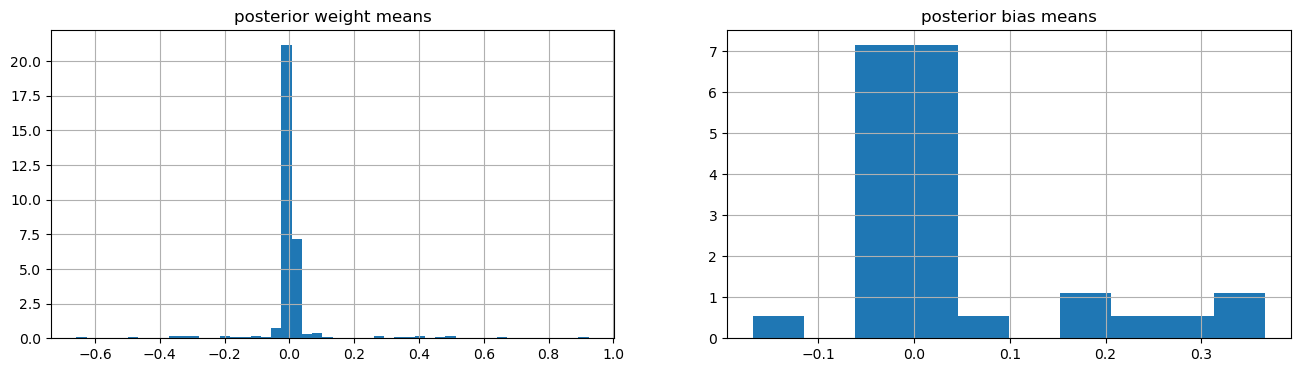

In [31]:
plt.rc('figure', figsize=(16, 4))

plt.subplot(121)
plt.hist(weightsM,50,density=True);
plt.title('posterior weight means')
plt.grid(True)

plt.subplot(122)
plt.hist(biasesM,10,density=True);
plt.title('posterior bias means')
plt.grid(True)

## look at signal/noise in weights

In [32]:
weightsS2N = weightsM/weightsS

/tmp/ipykernel_15063/2412286632.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(311)


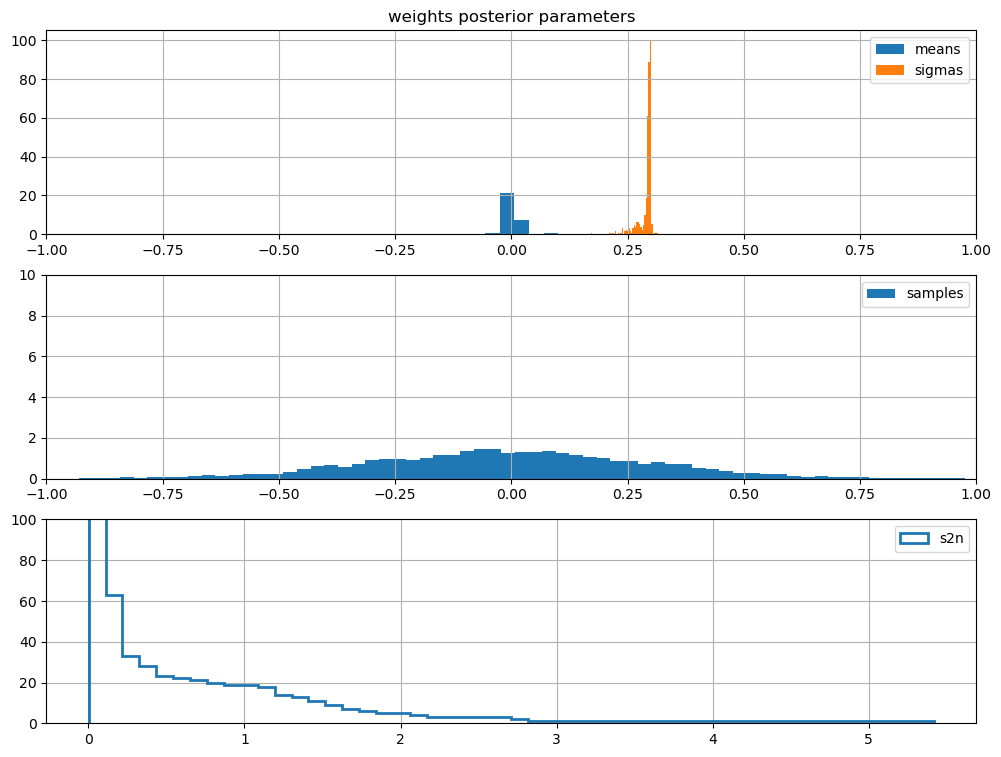

In [33]:
plt.rc('figure', figsize=(12, 9))

plt.title('weights posterior parameters')

plt.subplot(311)
plt.hist(weightsM, 50, density=True, label='means');
plt.hist(weightsS, 50, density=True, label='sigmas');
# plt.hist(np.abs(weightsS2N), 50, density=False, label='s2n', alpha=0.5);
plt.grid(True)
plt.xlim(-1,1)
# plt.xlim(-0.5,3)
# plt.ylim(0,10)
plt.legend()
plt.title('weights posterior parameters')

plt.subplot(312)
plt.hist(weight_samples, 100, density=True, label='samples');
plt.grid(True)
plt.xlim(-1,1)
plt.ylim(0,10)
plt.legend()

plt.subplot(313)
# plt.hist(weightsM, 50, density=True, label='means');
# plt.hist(weightsS, 50, density=True, label='sigmas');
plt.hist(np.abs(weightsS2N), 50, density=False, histtype='step',
                           cumulative=-1, label='s2n', linewidth=2);
# plt.hist(np.abs(weightsS2N), 50, density=False, histtype='step',
#                            cumulative=True, label='s2n', linewidth=2);
# plt.hist(np.abs(weightsS2N), 50, density=True);
plt.grid(True)
# plt.xlim(-0.5,3)
plt.ylim(0,100)
plt.legend()

# plt.savefig('figures/posteriors3_priorNormal0.3_complexityWeight52.png')

# Inference

## predict whole study area

### two approaches possible: 
 - (1) sample entire study area many times to derive mean, stddev, and confidence - fast
 - (2) sample entire study area many times to compute cdf, then derive mode and quantiles - slow

In [34]:
# this saves memory on gpu, but is slow and doesn't work well with batchnorm

# eval_loader = DataLoader(Tensor(Xall).to(DEVICE), shuffle=False, 
#                          batch_size=8192, drop_last=False)

# net.eval()
# net.to(DEVICE)

# pm = []
# ps = []
# for features in tqdm(eval_loader):
#     with torch.no_grad():
#         p = net.mfvi_forward(features, sample_nbr=1024)
#         m = p[0].squeeze() # means
#         s = p[1].squeeze() # stddevs

#         pm.append(m)
#         ps.append(s)

# m = torch.cat(pm, dim=0)
# s = torch.cat(ps, dim=0)

In [35]:
# net.eval()

# net.to('cuda')l
# features = Tensor(Xall).to('cuda')

# t0 = time.time()
# with torch.no_grad():
#     p = net.mfvi_forward(features, stat='mean', q=0.1, sample_nbr=64)
#     m = p.squeeze() # means
# #     p2 = net.mfvi_forward(features, stat='stddev', q=0.1, sample_nbr=64)
# #     s = p2.squeeze() # means
# print ('Inference time = ', time.time()-t0)

## this version does softmax internally and outputs probabilities

In [36]:
quantile = 0.05

In [37]:
# inference in batches
# this saves memory on gpu, but is slow 
# and has irregularities due to random number seeds among batches

eval_loader = DataLoader(Tensor(Xall).to(DEVICE), shuffle=False, 
                         batch_size=4096, drop_last=False)

###########################################
t0 = time.time()
###########################################

net.eval()
net.to(DEVICE)

pProbAll = []
for features in tqdm(eval_loader):
    with torch.no_grad():
        # p = net.mfvi_forward(features, stat='quantile', q=quantile, sample_nbr=1024)
        p = net.mfvi_forward(features, stat='quantile', q=quantile, sample_nbr=128)
        # p = net.mfvi_forward(features, stat='quantile', q=quantile, sample_nbr=8192)
        # p = net.mfvi_forward(features, stat='mean', q=None, sample_nbr=128)
        # p = net.mfvi_forward(features, stat='stddev', q=None, sample_nbr=8192)
        # p = net.mfvi_forward(features, stat='stddev', q=None, sample_nbr=128)
        p = p.squeeze()
        pProbAll.append(p)
        
pProbAll = torch.cat(pProbAll, dim=0)

###########################################
print ('Inference time = ', time.time()-t0)
###########################################

  0%|          | 0/422 [00:00<?, ?it/s]

Inference time =  33.698686361312866


In [38]:
pProbAll.shape

torch.Size([1728000, 2])

In [39]:
pProbAll = pProbAll.cpu().detach().numpy()
pProbAll.shape

(1728000, 2)

## plot a histogram

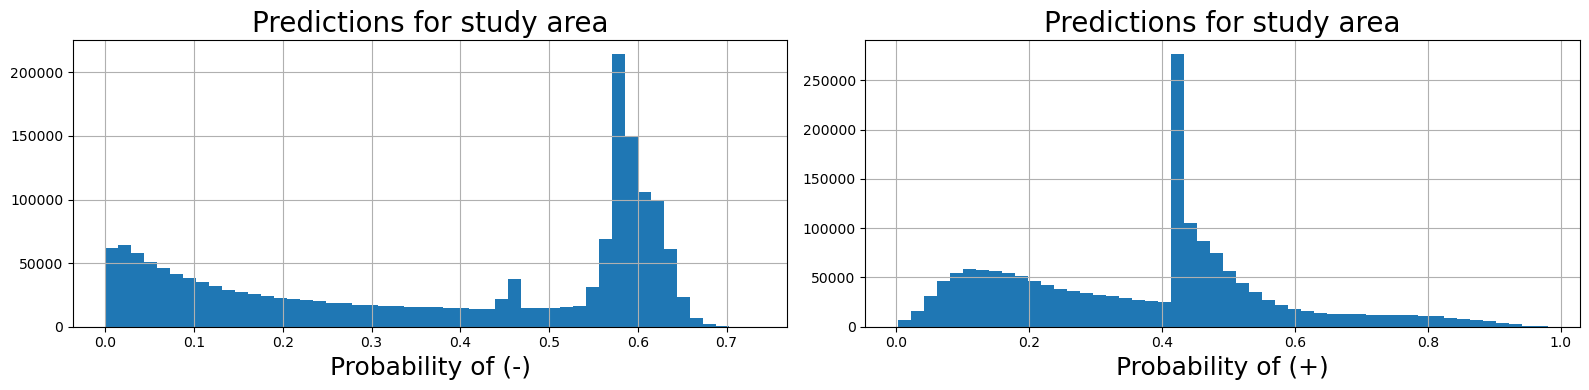

In [40]:
plt.rc('figure', figsize=(16,4))

plt.subplot(121)
plt.hist(pProbAll[:,0],50);
plt.grid(True)

plt.title('Predictions for study area',fontsize=20)
plt.xlabel('Probability of (-)',fontsize=18)

plt.subplot(122)
plt.hist(pProbAll[:,1],50);
plt.grid(True)

plt.title('Predictions for study area',fontsize=20)
plt.xlabel('Probability of (+)',fontsize=18)

plt.tight_layout()

# plt.savefig('prob_predict_study_area_fixedComplexityWeights.png')

In [41]:
# choose which site type to look at

siteType = 1

if siteType == 0:
    # negative
    classLabel = '(-)'
    pProb = pProbAll[:,0].copy()
    
elif siteType == 1:
    # positive
    classLabel = '(+)'
    pProb = pProbAll[:,1].copy()

## plot maps

In [42]:
# mask nulls for image

pProb[nullIndexes] = np.nan

In [43]:
img0 = np.reshape(pProb,(1000,-1))

img0.shape

(1000, 1728)

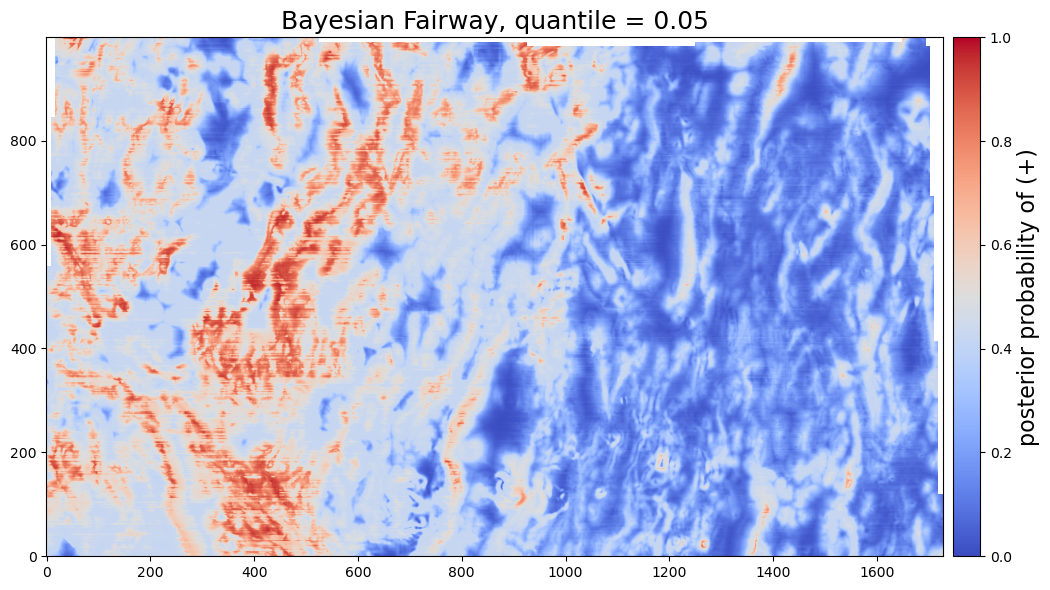

In [44]:
import matplotlib.colors as colors

from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(12,6))

im = plt.imshow(img0, origin='lower', cmap='coolwarm', 
                vmin=0, vmax=1.0,
                # vmin=0, vmax=0.25,
#                 interpolation='gaussian',
#                 norm=colors.Normalize(vmin=0.0, vmax=1.0)
#                 norm=colors.SymLogNorm(linthresh=0.3, linscale=0.3, vmin=-1.0, vmax=1.0, base=10))
               )

# plt.title('"new" Fairway - categorical localK', fontsize=18)
plt.title('Bayesian Fairway, quantile = '+str(quantile), fontsize=18)
# plt.title('Bayesian Fairway, mean', fontsize=18)
# plt.title('Bayesian Fairway, stddev', fontsize=18)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)

cb = plt.colorbar(im, cax=cax)
cb.set_label('posterior probability of '+classLabel,fontsize=16)

plt.tight_layout()

# plt.savefig('nFairway_'+outFileRoot+'_'+classLabel+'_quantile_'+str(quantile)+'_avg_8192'+'_600dpi'+'.png', dpi=600)
# plt.savefig('nFairway_'+outFileRoot+'_'+classLabel+'_mean'+'_avg_8192'+'_600dpi'+'.png', dpi=600)
# plt.savefig('nFairway_'+outFileRoot+'_'+classLabel+'_stddev'+'_avg_8192'+'_600dpi'+'.png', dpi=600)

# plt.savefig('figures/statsMaps/nFairway_'+outFileRoot+'_'+classLabel+'_percentile_'+str(quantile)+'.png')
# plt.savefig('nFairway_numericalLocalK_finetune.png')
# plt.savefig('nFairway_categoricalLocalK_finetune.png')
# plt.savefig('nFairway_smoothedLocalK.png')

## plot benchmark sites onto map

In [45]:
XyInfo = pd.read_hdf(hf5File, key='XyInfo')
# XyInfo

In [46]:
benchmarks = XyInfo[['row', 'column', 'TrainCodePos']].copy()
benchmarks.rename({'TrainCodePos': 'label'}, axis='columns', inplace=True)

In [47]:
benchmarks.loc[benchmarks.label <= 2, 'label'] = 1
benchmarks.loc[benchmarks.label > 2, 'label'] = 0

benchmarks

,row,column,label
1629211,942.0,1435.0,1
792748,458.0,1324.0,0
1427233,825.0,1633.0,0
630421,364.0,1429.0,0
741007,428.0,1423.0,0
...,...,...,...
1486117,860.0,37.0,1
1358832,786.0,624.0,1
727151,420.0,1391.0,0
641753,371.0,665.0,1


In [48]:
benchmarks = benchmarks.astype(int)

benchmarks = benchmarks.to_numpy()


In [49]:
row = benchmarks[:,0]
col = benchmarks[:,1]
label = benchmarks[:,2]

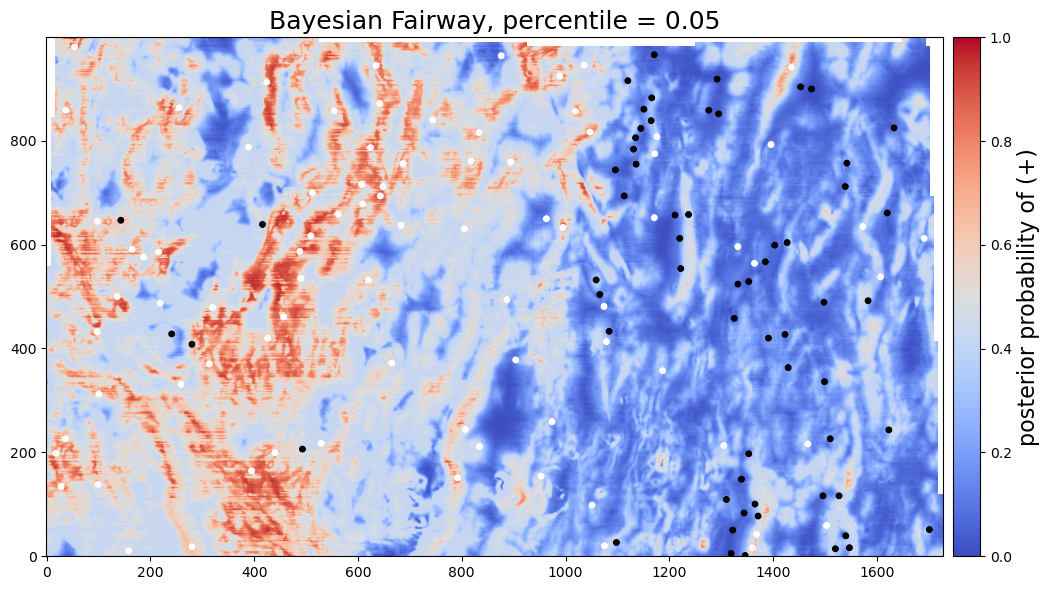

In [50]:
fig, ax = plt.subplots(figsize=(12,6))

im = plt.imshow(img0, origin='lower', cmap='coolwarm', 
                vmin=0.0, vmax=1.0,
#                 interpolation='gaussian',
#                 norm=colors.Normalize(vmin=0.0, vmax=1.0)
#                 norm=colors.SymLogNorm(linthresh=0.3, linscale=0.3, vmin=-1.0, vmax=1.0, base=10))
               )

plt.scatter(col, row, c=label, s=10, cmap='gray')

# plt.title('"new" Fairway - categorical localK', fontsize=18)
plt.title('Bayesian Fairway, percentile = '+str(quantile), fontsize=18)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)

cb = plt.colorbar(im, cax=cax)
cb.set_label('posterior probability of '+classLabel,fontsize=16)

plt.tight_layout()

# plt.savefig('figures/statsMaps/nFairway_'+'benchmarks_'+outFileRoot+'_'+classLabel+'_percentile_'+str(quantile)+'.png')
# plt.savefig('figures/nFairway_with_benchmarks_featureSet2.png', dpi=300)

In [ ]:
# xxx

## save maps as geotiffs

In [ ]:
import osgeo.gdal as gdal
import osgeo.osr as osr

In [ ]:
transform = [286202.6902, 250.0, 0.0, 4508588.7659, 0.0, -250.0]

In [ ]:
img0 = np.flipud(img0)
# img1 = np.flipud(imgm)
# img2 = np.flipud(imgmax)

In [ ]:
height = img0.shape[0]
width = img0.shape[1]
print (width, height)

In [ ]:
# open a new file
# geotiffFile = 'figures/statsMaps/nFairway_'+outFileRoot+'_'+classLabel+'_percentile_'+str(quantile)+'.tif'
# geotiffFile = 'nFairway_'+outFileRoot+'_'+classLabel+'_quantile_'+str(quantile)+'_avg_8192'+'.tif'

# geotiffFile = 'nFairway_'+outFileRoot+'_'+classLabel+'_mean'+'_avg_8192'+'.tif'
geotiffFile = 'BNN_'+classLabel+'_q-'+str(quantile)+'_avg-8192'+'.tif'

driver = gdal.GetDriverByName("GTiff")
outRaster = driver.Create(geotiffFile, width, height, 1, gdal.GDT_Float32)

# use PFA's geo-transform found above
outRaster.SetGeoTransform(transform)

# assign color band
outband = outRaster.GetRasterBand(1)
outband.WriteArray(img0)

# set coordinate reference system
outRasterSRS = osr.SpatialReference() # create instance of class
outRasterSRS.ImportFromEPSG(26911)    # set to specific coordinate reference system
# outRasterSRS.ImportFromWkt(raster.GetProjectionRef()) # or could use SRS from before
outRaster.SetProjection(outRasterSRS.ExportToWkt()) # set the projection

# flush output to file
outband.FlushCache()

# this closes the files
raster = None
outRaster = None

In [ ]:
xxx